## DATA

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [ ]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels as sm

from scipy.stats import kstest
from sklearn.metrics import r2_score

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [ ]:
start = datetime.date(2020,1,1)
end = datetime.date(2021,1,1)
HSI = pd.DataFrame(web.DataReader('^HSI','yahoo',start,end).iloc[:,3])
HSI.tail()

,Close
Date,
2020-12-24,26386.560547
2020-12-28,26314.630859
2020-12-29,26568.490234
2020-12-30,27147.109375
2020-12-31,27231.130859


In [ ]:
# 取log return
HSI['Close'] = HSI['Close'] / HSI['Close'].shift(1)
HSI['Close'] = HSI['Close'].apply(np.log)

HSI = HSI.dropna()
HSI.columns = ['Return']
HSI.tail()

,Return
Date,
2020-12-24,0.001648
2020-12-28,-0.002730
2020-12-29,0.009601
2020-12-30,0.021545
2020-12-31,0.003090


## Experiment

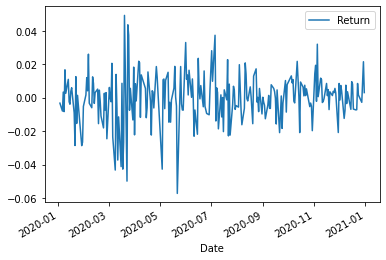

In [ ]:
HSI.plot()

### LB test

In [ ]:
# 检验是否为相关序列，p值大则不是

acorr_ljungbox(HSI['Return'].values, lags=10)[1]

array([0.21655369, 0.45059208, 0.35046741, 0.34580351, 0.22969771,
       0.09821605, 0.14658338, 0.18024183, 0.21250528, 0.26637177])

In [ ]:
# 检验是否正态分布, p值大则是

a = HSI.values.flatten()
a = (a - a.mean()) / a.std()
kstest(a, 'norm')

KstestResult(statistic=0.09617093123039425, pvalue=0.019344253402844444)

### 单位根检查

In [ ]:
# index 1为p值，过小则显示无单位根

dftest = adfuller(HSI['Return'], autolag='AIC')
dftest

(-16.892975695115467,
 1.0416655650459056e-29,
 0,
 246,
 {'1%': -3.457215237265747,
  '10%': -2.5730700760129555,
  '5%': -2.873361841566324},
 -1280.5914499646378)

### ARMA定阶

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


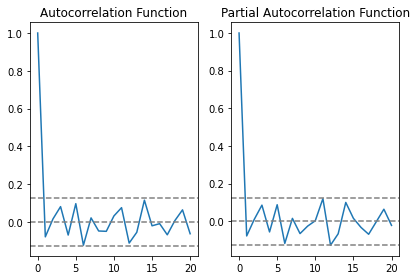

In [ ]:
# 判断截尾，但是人工可能不准确
# AR系数用PACF，MA系数用ACF，观察最早vanish到y=0的阶

lag_acf = acf(HSI['Return'].values, nlags=20)
lag_pacf = pacf(HSI['Return'].values, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(HSI['Return'].values)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(HSI['Return'].values)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(HSI['Return'].values)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(HSI['Return'].values)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()    

In [ ]:
sm.tsa.stattools.arma_order_select_ic(HSI['Return'].values, max_ar=4, max_ma=4, ic='aic')

### 拟合

In [ ]:
model = ARMA(HSI['Return'].values, order=(3,1)).fit()

In [ ]:
ret_pred = model.predict()

In [ ]:
r2_score(HSI['Return'].values, ret_pred)